In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
local_zip = "/content/gdrive/MyDrive/Colab Notebooks/is_it_pizza.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
pizza_images = os.listdir('/tmp/pizza_not_pizza/pizza')
not_pizza_images = os.listdir('/tmp/pizza_not_pizza/not_pizza')

In [ ]:
print(len(pizza_images))
print(len(not_pizza_images))

983
983


In [ ]:
try:
  os.mkdir("/tmp/pizza-not-pizza")
  os.mkdir("/tmp/pizza-not-pizza/training")
  os.mkdir("/tmp/pizza-not-pizza/test")
  os.mkdir("/tmp/pizza-not-pizza/training/pizza")
  os.mkdir("/tmp/pizza-not-pizza/training/not_pizza")
  os.mkdir("/tmp/pizza-not-pizza/test/pizza")
  os.mkdir("/tmp/pizza-not-pizza/test/not_pizza")
except OSError:
  pass

In [ ]:
# to avoid bias, randomly assigne images to training or testing
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


PIZZA_SOURCE_DIR = "/tmp/pizza_not_pizza/pizza/"
TRAINING_PIZZA_DIR = "/tmp/pizza-not-pizza/training/pizza/"
TEST_PIZZA_DIR = "/tmp/pizza-not-pizza/test/pizza/"
NOT_PIZZA_SOURCE_DIR = "/tmp/pizza_not_pizza/not_pizza/"
TRAINING_NOT_PIZZA_DIR = "/tmp/pizza-not-pizza/training/not_pizza/"
TEST_NOT_PIZZA_DIR = "/tmp/pizza-not-pizza/test/not_pizza/"

split_size = .9
split_data(PIZZA_SOURCE_DIR, TRAINING_PIZZA_DIR, TEST_PIZZA_DIR, split_size)
split_data(NOT_PIZZA_SOURCE_DIR, TRAINING_NOT_PIZZA_DIR, TEST_NOT_PIZZA_DIR, split_size)

In [ ]:
print(len(os.listdir('/tmp/pizza-not-pizza/training/pizza/')))
print(len(os.listdir('/tmp/pizza-not-pizza/test/pizza/')))
print(len(os.listdir('/tmp/pizza-not-pizza/training/not_pizza/')))
print(len(os.listdir('/tmp/pizza-not-pizza/test/not_pizza/')))

884
99
884
99


In [ ]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83697664/83683744 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
model.compile(optimizer=RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
TRAINING_DIR = "/tmp/pizza-not-pizza/training"
train_datagen = ImageDataGenerator(rescale=1.0/255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip=True, vertical_flip= True, preprocessing_function= tf.keras.applications.resnet50.preprocess_input)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size = 52,
    class_mode = 'binary',
    target_size = (150, 150))

VALIDATION_DIR = "/tmp/pizza-not-pizza/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 9,
    class_mode = 'binary',
    target_size = (150, 150))

Found 1768 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator, epochs = 5, steps_per_epoch = 17, 
                    validation_data = validation_generator, validation_steps = 11)

Epoch 1/5
17/17 [==============================] - 63s 4s/step - loss: 0.5408 - accuracy: 0.7183 - val_loss: 0.3272 - val_accuracy: 0.8384
Epoch 2/5
17/17 [==============================] - 59s 3s/step - loss: 0.3849 - accuracy: 0.8507 - val_loss: 0.2957 - val_accuracy: 0.8586
Epoch 3/5
17/17 [==============================] - 59s 3s/step - loss: 0.3489 - accuracy: 0.8552 - val_loss: 0.2211 - val_accuracy: 0.9091
Epoch 4/5
17/17 [==============================] - 59s 3s/step - loss: 0.3173 - accuracy: 0.8609 - val_loss: 0.1686 - val_accuracy: 0.9596
Epoch 5/5
17/17 [==============================] - 60s 4s/step - loss: 0.3121 - accuracy: 0.8744 - val_loss: 0.2021 - val_accuracy: 0.9192


<Figure size 432x288 with 0 Axes>

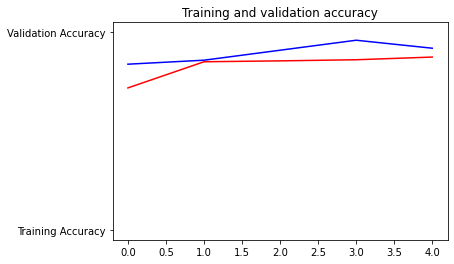

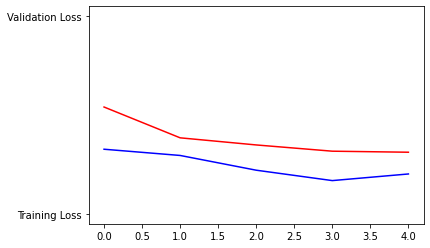

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. 